# Calibrating pulses on `ibmq_casablanca`

The following notebook, and the corresponding code in [calibration_utils.py](../src/calibration_utils.py) has been wholly lifted and butchered from a [Section 6.2](./accessing_higher_energy_states.ipynb) of the
[qiskit textbook](https://qiskit.org/textbook/preface.html).
See the textbook for more details on the method presented here.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from src.calibration_utils import *
from src.plotting_utils import *

In this notebook we will look at calibrating pulses on `ibmq_casablanca`.
The results here are very similar those in [imbq_bogota_calibration.ipynb](./ibmq_bogota_calibration.ipynb).

In [2]:
calibration = Calibration(
    backend_name='ibmq_casablanca',
    qubit_idx=3,
    num_shots=8000,
    scale_factor=1e-6
)

Qubit 3 has an estimated frequency of 4.879094276254212 GHz.


## Calibrating a pulse for the $|0\rangle \leftrightarrow |1\rangle$ transition

### Frequency sweep

In [7]:
num_freqs = 75
ground_freq_sweep = calibration.default_qubit_freq + np.linspace(-10*MHz, 10*MHz, num_freqs)

ground_freq_sweep_job = calibration.run_ground_freq_sweep_program(
    freqs=ground_freq_sweep,
    drive_power=0.1
)

The frequency sweep will go from 4.869094276254211 GHz to 4.889094276254212 GHz using 75 frequencies. The drive power is 0.1.
Job ID: 6100ffce2cbc410125cba8da
Job Status: job has successfully run


In [8]:
ground_freq_sweep_data = get_job_data(
    ground_freq_sweep_job,
    average=True,
    qubit_idx=calibration.qubit,
    scale_factor=calibration.scale_factor
)

In [9]:
(ground_sweep_fit_params, ground_sweep_y_fit) = fit_function(
    ground_freq_sweep,
    ground_freq_sweep_data,
    lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
    [7, calibration.default_qubit_freq, 0.1*GHz, 3*GHz] # Initial parameters for curve_fit
)

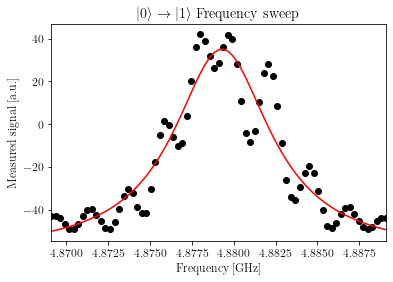

In [10]:
plt.scatter(ground_freq_sweep/GHz, ground_freq_sweep_data, color='black')
plt.plot(ground_freq_sweep/GHz, ground_sweep_y_fit, color='red')

plt.xlim([min(ground_freq_sweep/GHz), max(ground_freq_sweep/GHz)])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Measured signal [a.u.]')
plt.title(r'$|0\rangle \rightarrow |1\rangle$ Frequency sweep')

plt.show()

Now clearly our Lorenztian isn't exactly well-fitted to the data.
Let's see how this shakes out.

In [11]:
_, cal_qubit_freq, _, _ = ground_sweep_fit_params
print(f"We've updated our qubit frequency estimate from "
      f"{round(calibration.default_qubit_freq/GHz, 7)} GHz to {round(cal_qubit_freq/GHz, 7)} GHz.")

We've updated our qubit frequency estimate from 4.8790943 GHz to 4.8792959 GHz.


### Rabi experiment

In [13]:
num_rabi_points = 50

drive_amp_min = 0
drive_amp_max = 0.5
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [14]:
rabi_01_job = calibration.run_rabi_01_program(
    cal_qubit_freq=cal_qubit_freq,
    drive_amps=drive_amps
)

Job ID: 610110ac613c3e368432fed2
Job Status: job has successfully run


In [15]:
rabi_01_data = get_job_data(
    rabi_01_job,
    average=True,
    qubit_idx=calibration.qubit,
    scale_factor=calibration.scale_factor
)

In [16]:
rabi_01_data = np.real(baseline_remove(rabi_01_data))
(rabi_01_fit_params, rabi_01_y_fit) = fit_function(
    drive_amps,
    rabi_01_data,
    lambda x, A, B, drive_01_period, phi: (A*np.cos(2*np.pi*x/drive_01_period - phi) + B),
    [1.5, -1.5, 0.25, 0]
)

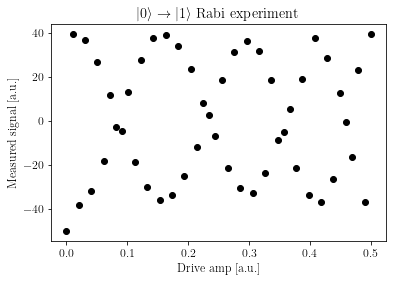

In [20]:
plt.scatter(drive_amps, rabi_01_data, color='black')
# plt.plot(drive_amps, rabi_01_y_fit, color='red')

drive_01_period = rabi_01_fit_params[2]
pi_amp_01 = (drive_01_period/2/np.pi) * (np.pi + rabi_01_fit_params[3])

# plt.axvline(pi_amp_01, color='red', linestyle='--')
# plt.axvline(pi_amp_01+drive_01_period/2, color='red', linestyle='--')
# plt.annotate("", xy=(pi_amp_01+drive_01_period/2, 0), xytext=(pi_amp_01,0), arrowprops=dict(arrowstyle="<->", color='red'))
# plt.annotate("$\pi$", xy=(pi_amp_01-0.03, 0.1), color='red')

plt.xlabel('Drive amp [a.u.]')
plt.ylabel('Measured signal [a.u.]')
plt.title(r'$|0\rangle \rightarrow |1\rangle$ Rabi experiment')

plt.show()

Unfortunately, the nearly peaks in the spectrum are leading to two competing effects.
We cannot fit the correct sinusoid.